## Truth-matching cut based on mass of parent for a partially reconstructed decay 

In this example, we select reconstructed pions and match them to their generated truth-level partners using the minumum angle method. We create $\tau \to 3\pi \nu$ candidates from the pions, using both the reco and matched truth-level tracks. The true decay involves a neutrino which is not reconstructed, but at the generator level we can add a neutrino to the three pions and check the invariant mass of this combination. We can then cut on the *true* mass of the parent, requiring it to be close to the PDG $\tau$ mass. In this way, we can select the genuine reconstructed $\tau$'s in our sample, separating them from the $3\pi$ combinations from other sources.

In [2]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file = uproot.open("/eos/experiment/fcc/ee/tmp/test.root")
tree = file['events']

Get the reco stable hadrons:

In [3]:
#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
h_c = "ReconstructedParticles"
h_container = f'{h_c}/{h_c}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and h_container in v):
        keep_vars.append(v)

h = tree.arrays(keep_vars,how="zip")
h[h_container,'p'] = kinematics.calc_p(h,h_container)
h_p_cut = h[h_container,'p'] > 2.
h = h[h_container][h_p_cut]

Keep only the pions:

In [4]:
pi_cut = abs(h['mass'] - abs(lp.pi_plus.mass)/1000.) < 1e-4
h = h[pi_cut]

Get the generated particles:

In [6]:
g_container = "Particle"
g = tree.arrays(filter_name=f"{g_container}*",how="zip")
g[g_container,'p'] = kinematics.calc_p(g,g_container)
g_p_cut = g[g_container,'p'] > 2.
g = g[g_container][g_p_cut]

Keep only the pions and neutrinos (to use later) from the generated particles:

In [7]:
g_pi_cut = abs(g['PDG']) == abs(lp.pi_plus.pdgid)
g_pi = g[g_pi_cut]
g_nu_cut = abs(g['PDG']) == abs(lp.nu_tau.pdgid)
g_nu = g[g_nu_cut]

Match the reco and true pions based on minimum angle:

In [8]:
pairs = ak.cartesian({"reco": h, "gen": g_pi}, nested=True)
pairs["costheta"] = kinematics.cos_angle(pairs["reco"], pairs["gen"])
best_pair = pairs[ak.singletons(ak.argmax(pairs["costheta"], axis=2))]
h["match"] = ak.firsts(best_pair, axis=2)

Invariant mass of the reco and matched true pair, keeping only those with physical charge combinations

In [9]:
threepi = ak.combinations(h["match"],3)
threepi["pi1"], threepi["pi2"], threepi["pi3"] = ak.unzip(threepi)

charge_cut = abs(threepi["pi1"]["reco","charge"] + threepi["pi2"]["reco","charge"] + threepi["pi3"]["reco","charge"]) == 1
threepi = threepi[charge_cut]

PDG_pi_m = lp.pi_plus.mass/1000.
for x in ["reco","gen"]:
    threepi[f"mass_{x}"] = kinematics.mass([threepi["pi1"][x],
                                            threepi["pi2"][x],
                                            threepi["pi3"][x]],
                                           [PDG_pi_m, 
                                            PDG_pi_m,
                                            PDG_pi_m])

Pair the true nuetrinos with the true $3\pi$ combinations:

In [10]:
tau = ak.cartesian({"threepi": threepi, "nu": g_nu})
PDG_nu_m = 0.
tau["mass_gen"] = kinematics.mass([tau["threepi"]["pi1"]["gen"],
                                   tau["threepi"]["pi2"]["gen"],
                                   tau["threepi"]["pi3"]["gen"],
                                   tau["nu"]],
                                  [PDG_pi_m, 
                                   PDG_pi_m,
                                   PDG_pi_m,
                                   PDG_nu_m])

Require that the true $m(3\pi\nu)$ is consistent with $m(\tau)$, and use that as a truth-matching requirement. Then plot the reconstructed $3\pi$ mass, up to a limit of $m(\tau)$. Show the events passing and failing the $\tau$ truth requirement separately.

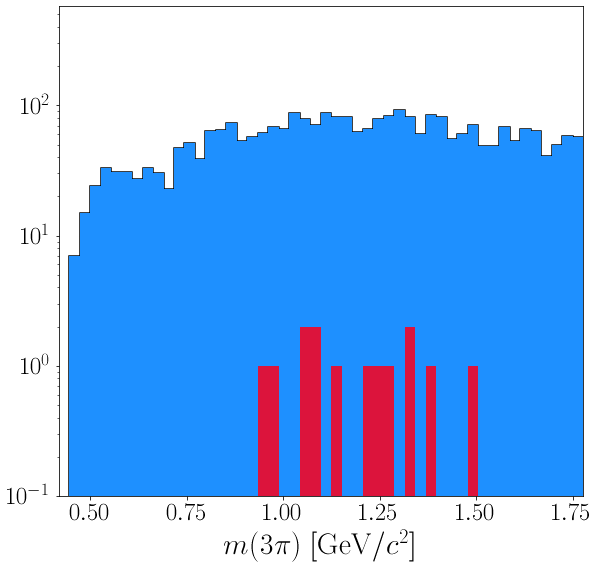

In [11]:
tau_PDG_m = lp.tau_plus.mass/1000.
low = 3*PDG_pi_m
high = tau_PDG_m

truth_cut = abs(tau["mass_gen"] - tau_PDG_m) < 0.0005

bins = 50
fig, ax = plt.subplots(figsize=(8,8))
#Total data
plt.hist(ak.flatten(tau["threepi"]["mass_reco"]),bins=bins,range=(low,high),histtype='step',color='k',linewidth=1.5)
#Filled to represent the fake taus
plt.hist(ak.flatten(tau["threepi"]["mass_reco"]),bins=bins,range=(low,high),histtype='stepfilled',color='dodgerblue',linewidth=1.5)
#Events passing the truth cut 
plt.hist(ak.flatten(tau["threepi"]["mass_reco"][truth_cut]),bins=bins,range=(low,high),histtype='stepfilled',color='crimson',linewidth=1.5)

plt.xlabel("$m(3\pi)$ [GeV/$c^2$]",fontsize=30)
plt.xlim(low,high)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.tight_layout()
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0.1,ymax*5.)
plt.show()
fig.savefig(f"{loc.PLOTS}/tau23pi_MC_match.pdf")